In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [4]:
# 加载数据
filepath_onlineshop = '../data/onlineShop/online_shoppers_intention.csv'
data_df = pd.read_csv(filepath_onlineshop,sep=",")

In [5]:
'''
视图
'''
# 条形图
def pltbar(x,y):
    plt.bar(x,y)
    plt.xticks(range(len(x)),x)
    plt.show()
# 饼图
def pltpie(x, lable = None, lableNum=0,pctdistance = 0.6,pieinterval = 1):
    # 通过lableSize区间确定pieinterval的值
    if lableNum == 0 or isinstance(lable,np.ndarray):
        print("auto operation pctdistance and lableNum")
        lableNum = x.size
        if lableNum>20:
            pieinterval = 0.6
        elif lableNum >10:
            pieinterval = 0.3
        elif lableNum > 2:
            pieinterval = 0.2
        else: 
            pieinterval = 0.1
    # 分配每个扇区与中心的距离
    explode = [(i+1)/lableNum*pieinterval for i in range(lableNum)]
    plt.pie(x,labels=lable,autopct="%0.2f%%",pctdistance = pctdistance,explode=explode)
    plt.show()
# 离散数据点图
def pltpoint(x,y):
    plt.scatter(x,y)
    plt.show()

In [6]:
# 筛选数据
# 拆分数据类型(默认为object)
def getDataTypeList(data_df,dt=np.dtype('O')):
    return list(data_df.dtypes[(data_df.dtypes==dt).values].index.values),list(data_df.dtypes[(data_df.dtypes!=dt).values].index.values)

# 获取含有空值的列标签
def getNullList(data_df):
    nullDataList = data_df.isnull().any()# 查看数据是否有空值
    return nullDataList

# 简易去除函数
def delNullData(data_df):
    data_df.dropna()
    return data_df

In [193]:
# 统计数据
# 统计类别个数中的类别量
def statisticOneLabelWithClass(data_df:pd.DataFrame,labels,ylabel):
    ylabelData = data_df[ylabel]
    ylabelCount = data_df[ylabel].value_counts()
    ylabelclassesname = ylabelCount.index.values
    ylabeldeclass = dict()
    for iyl in ylabelclassesname:
        ylabeldeclass[iyl] = (data_df[ylabelData == iyl][labels])
    return ylabeldeclass

# 某一类别的数据分布
def statisticOneLabel(data_df:pd.DataFrame,label=None):
    if(label != None):
        data_df = data_df[label]
    else:
        label = 1
    data_df = pd.DataFrame(data_df.values)
    return data_df.value_counts().sort_index()

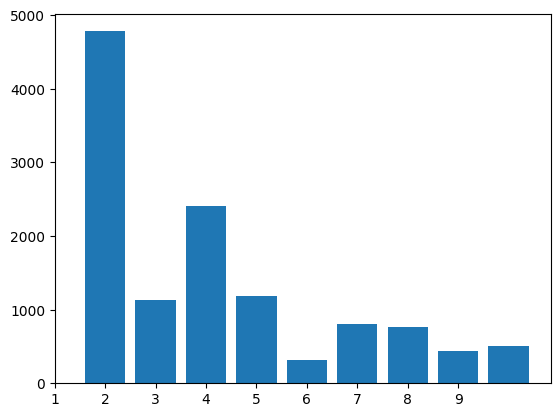

In [219]:
# 单个数据进行统计测试
statisticOneLabelWithClass(data_df,['Browser','Region'],'Revenue')
dt = statisticOneLabel(data_df,'Region')
pltbar([i[0] for i in dt.index],dt.values.tolist())


In [ ]:
# 需要关注的量
'''
1、唯一值比例
2、特征之间的相关系数

'''
# 当前使用的流程
'''
1、数据去除空值
2、对数据进行分类，拆分出object类型和数值类型，Object根据唯一值比例判断是否进行one-hot处理
3、数值类型首先判断是否需要标准化，根据不同数据进行皮尔逊相关系数计算。
4、根据相关系数情况判断是否需要进行数据横向扩展
5、构建模型
6、根据模型训练出的数据调整4，直至auc或F1达到预期
'''

In [7]:
getDataTypeList(data_df)

(['Month', 'VisitorType'],
 ['Administrative',
  'Administrative_Duration',
  'Informational',
  'Informational_Duration',
  'ProductRelated',
  'ProductRelated_Duration',
  'BounceRates',
  'ExitRates',
  'PageValues',
  'SpecialDay',
  'OperatingSystems',
  'Browser',
  'Region',
  'TrafficType',
  'Weekend',
  'Revenue'])

In [9]:
'''基本数据处理'''
def statistics(data_df):
    df_label_counts = dict()
    df_label_values_counts = dict()
    for k in data_df.keys():
        df_label_values_counts[k] = data_df[k].value_counts()
        df_label_counts[k] = len(df_label_values_counts[k].keys())
    return df_label_counts,df_label_values_counts

# 拆分出数据较少的
def sparseData(df_label_counts,df_label_values_counts,MaxCountNum = 60,isplt = False):
    sparselabel = []
    dencelabel = []
    for ikey in df_label_counts.keys():
        if(df_label_counts[ikey] < MaxCountNum or MaxCountNum == 0):
            sparselabel.append(ikey)
            continue
        dencelabel.append(ikey)
    if isplt:
        for i in sparselabel:
            print(i)
            mes_k_count = df_label_values_counts[i]
            x = mes_k_count.index.values
            y = mes_k_count.values
            pltpie(y,lable=x)
    return sparselabel,dencelabel



In [21]:
# 检测数据之间的相关性
# 皮尔逊相关系数
def pearsonr(x,y):
#     x = torch.tensor(x)
#     y = torch.tensor(y)
    x = x/np.sum(x)
    y = y/np.sum(y)
    n=len(x)
    sum_xy = np.sum(np.sum(x*y))
    sum_x = np.sum(np.sum(x))
    sum_y = np.sum(np.sum(y))
    sum_x2 = np.sum(np.sum(x*x))
    sum_y2 = np.sum(np.sum(y*y))
    fz = n*sum_xy-sum_x*sum_y
    fm = np.sqrt((n*sum_x2-sum_x*sum_x)*(n*sum_y2-sum_y*sum_y))
    return fz/fm

# 多个系数
def pearsonrs(data_df,labels):
    ddf = data_df[labels].values
    lenLabel = len(labels)
    matData = torch.zeros([lenLabel,lenLabel])
    for i in range(lenLabel):
        for j in range(lenLabel):
            if(i == j):
                matData[j][i] = 1
                break
            x = data_df[labels[i]].values
            y = data_df[labels[j]].values
            c = pearsonr(x,y)
            if(c>1):
                c = 0
                print(i,j)
            elif(c<0):
                c = -c
            matData[i][j] = c
            if(i != j):
                matData[j][i] = c
            print(i,j,c)
    return matData

In [11]:
# 绘图
def drowLabelPie(labels,df_label_values_counts):
    for i in labels:
        print(i)
        mes_k_count = df_label_values_counts[i]
        x = mes_k_count.index.values
        y = mes_k_count.values
        pltpie(y,lable=x)

In [12]:
df_label_counts,df_label_values_counts = statistics(data_df)# 获取每个标签个数，每个标签数据的统计个数

Administrative
auto operation pctdistance and lableNum


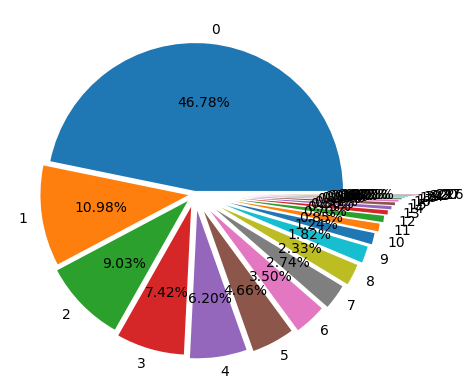

Informational
auto operation pctdistance and lableNum


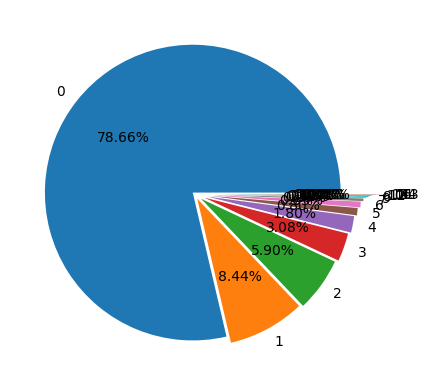

SpecialDay
auto operation pctdistance and lableNum


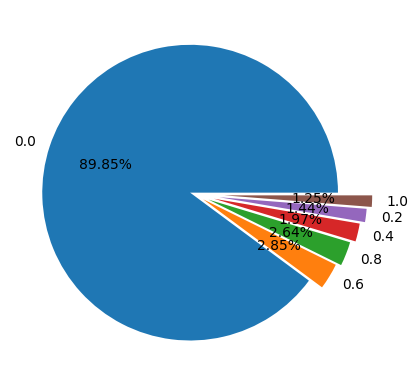

Month
auto operation pctdistance and lableNum


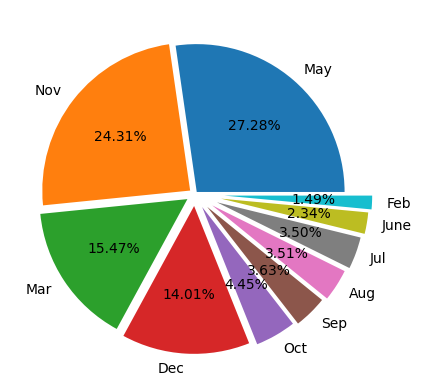

OperatingSystems
auto operation pctdistance and lableNum


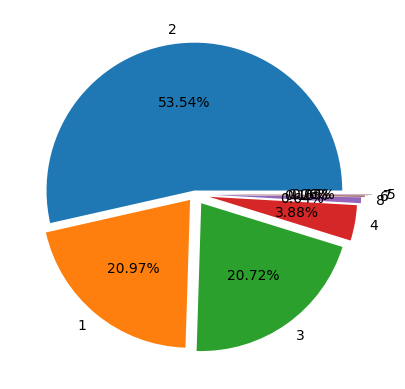

Browser
auto operation pctdistance and lableNum


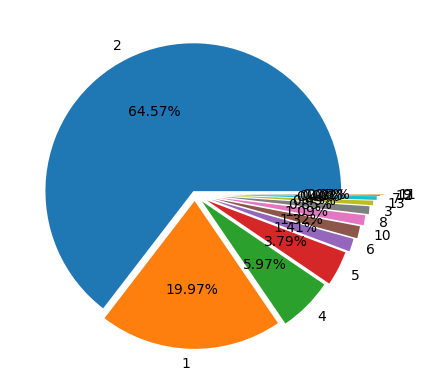

Region
auto operation pctdistance and lableNum


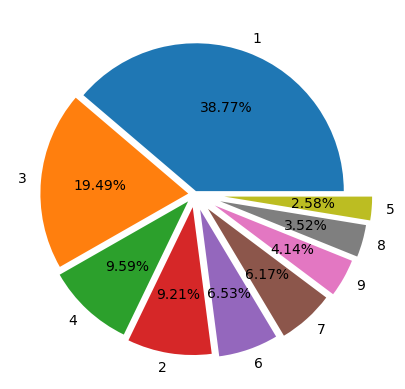

TrafficType
auto operation pctdistance and lableNum


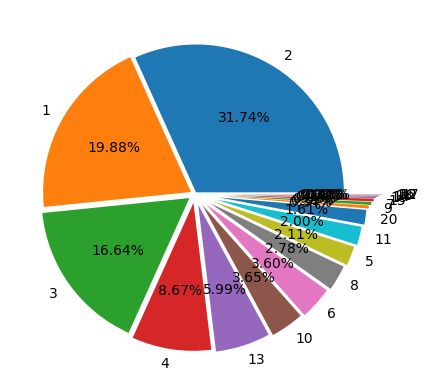

VisitorType
auto operation pctdistance and lableNum


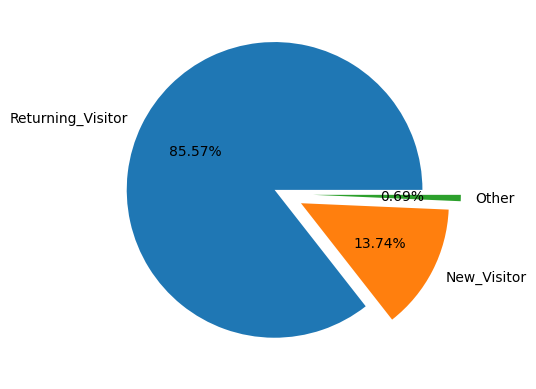

Weekend
auto operation pctdistance and lableNum


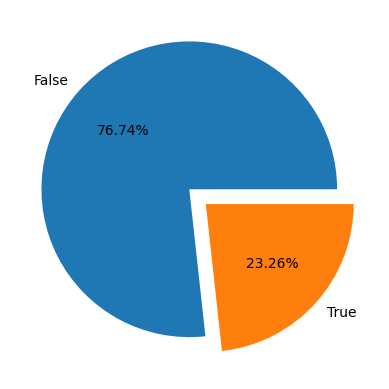

Revenue
auto operation pctdistance and lableNum


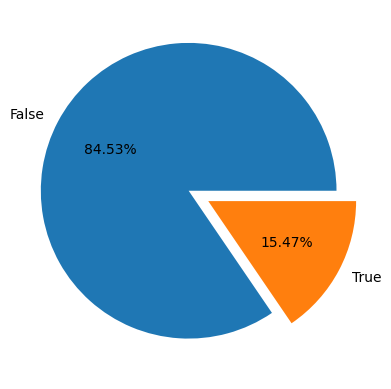

In [13]:
sparselabel,dencelabel = sparseData(df_label_counts,df_label_values_counts,isplt=True)

In [22]:
# 单个皮尔逊
x = data_df['OperatingSystems'].values
y = data_df['Browser'].values
pearsonr(x,y)

0.2230128882474721

In [57]:
# 预处理过程
'''
1、去除空值
2、统计label个数，通过labels限定类型
3、对label数据少且满足需要的进行one-hot处理
4、计算相似度
5、选择去除相似数据
'''
data_df = delNullData(data_df)
data_df_o,data_df_n = getDataTypeList(data_df)

In [58]:
persn = pearsonrs(data_df,data_df_n)
persn = pd.DataFrame(persn) 
# .fillna(0)

1 0 0.6015833421250226
2 0 0.37685042930730756
2 1 0.30270970897576005
3 0 0.2558481402326258
3 1 0.2380307893499993
3 2 0.6189548617814569
4 0 0.43111933962453586
4 1 0.289086621406217
4 2 0.3741642906577268
4 3 0.28004626785919645
5 0 0.3739390129596699
5 1 0.355421953501631
5 2 0.38750530625986146
5 3 0.34736357744649493
5 4 0.86092683617637
6 0 0.22356263038422564
6 1 0.14417040950711404
6 2 0.11611361638719078
6 3 0.0740666098957207
6 4 0.2045776333507534
6 5 0.18454111529428477
7 0 0.31648299752725223
7 1 0.20579775727445584
7 2 0.16366606078450036
7 3 0.10527568334787342
7 4 0.29252628311358053
7 5 0.25198409740610467
7 6 0.9130043961815212
8 0 0.09898958539971282
8 1 0.0676084808703492
8 2 0.04863169195374337
8 3 0.030860873716780104
8 4 0.05628179410884907
8 5 0.052823062950143926
8 6 0.11938602629479454
8 7 0.1744983100017819
9 0 0.09477759754428272
9 1 0.07330372492125972
9 2 0.048219253989528234
9 3 0.030576549486372107
9 4 0.023958174724005986
9 5 0.03637984509738727
9 6 0

In [59]:
persn.index = data_df_n
persn.columns = data_df_n
persn

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,0.223563,0.316483,0.098990,0.094778,0.006347,0.025035,0.005487,0.033561,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,0.144170,0.205798,0.067608,0.073304,0.007343,0.015392,0.005561,0.014376,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,0.116114,0.163666,0.048632,0.048219,0.009527,0.038235,0.029169,0.034491,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,0.074067,0.105276,0.030861,0.030577,0.009579,0.019285,0.027144,0.024675,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,0.204578,0.292526,0.056282,0.023958,0.004290,0.013146,0.038122,0.043064,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,0.184541,0.251984,0.052823,0.036380,0.002976,0.007380,0.033091,0.036377,0.007311,0.152373
BounceRates,0.223563,0.144170,0.116114,0.074067,0.204578,0.184541,1.000000,0.913004,0.119386,0.072702,0.023823,0.015772,0.006485,0.078286,0.046514,0.150673
ExitRates,0.316483,0.205798,0.163666,0.105276,0.292526,0.251984,0.913004,1.000000,0.174498,0.102242,0.014567,0.004442,0.008907,0.078616,0.062587,0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,0.119386,0.174498,1.000000,0.063541,0.018508,0.045592,0.011315,0.012532,0.012002,0.492569
SpecialDay,0.094778,0.073304,0.048219,0.030577,0.023958,0.036380,0.072702,0.102242,0.063541,1.000000,0.012652,0.003499,0.016098,0.052301,0.016767,0.082305


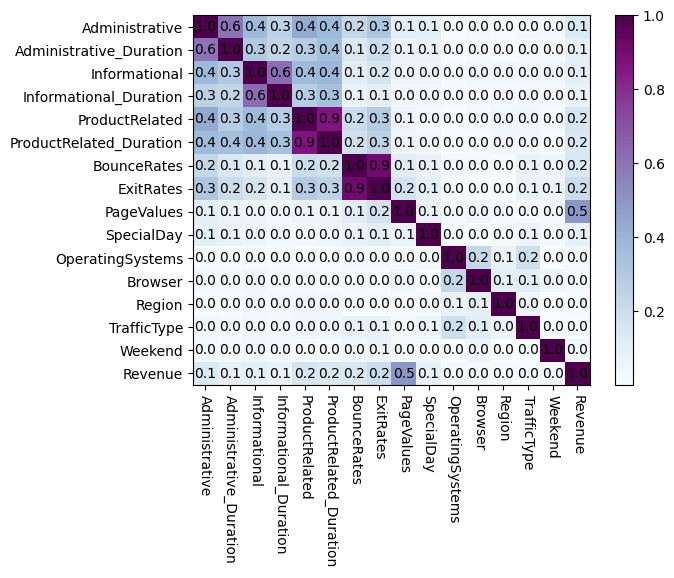

In [60]:
plt.imshow(persn,cmap='BuPu',norm='linear',origin='upper',aspect='auto')
plt.colorbar()
lenpersn = 16
plt.xticks(ticks = np.arange(0,lenpersn),rotation=270,labels=data_df_n)
plt.yticks(ticks=np.arange(0,lenpersn),labels=data_df_n)
for i in range(persn.shape[1]):
    for j in range(persn.shape[0]):
        # print(i,j,persn.iloc[i,j])
        plt.text(j,i,round(persn.iloc[i,j],1),ha='center',va='center')

Administrative
auto operation pctdistance and lableNum


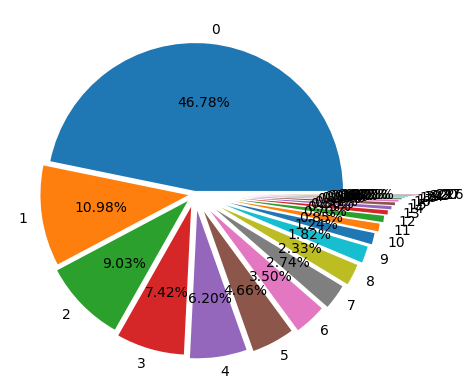

Administrative_Duration
auto operation pctdistance and lableNum


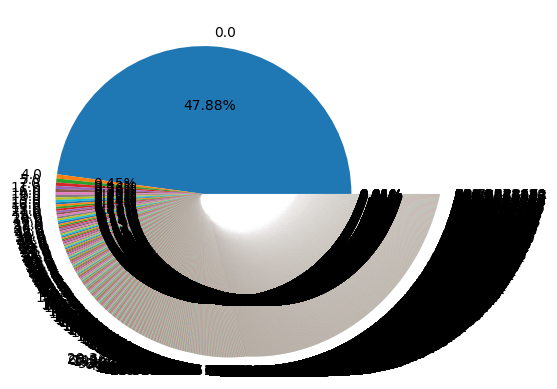

Informational
auto operation pctdistance and lableNum


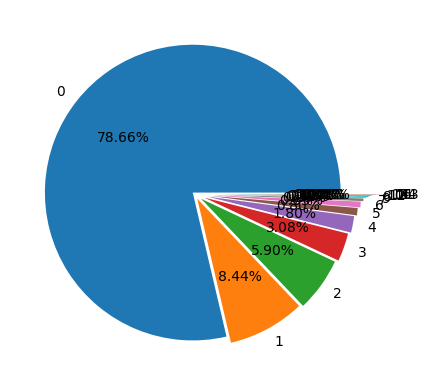

Informational_Duration
auto operation pctdistance and lableNum


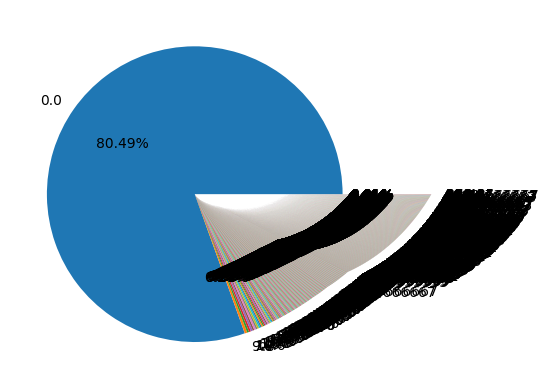

ProductRelated
auto operation pctdistance and lableNum


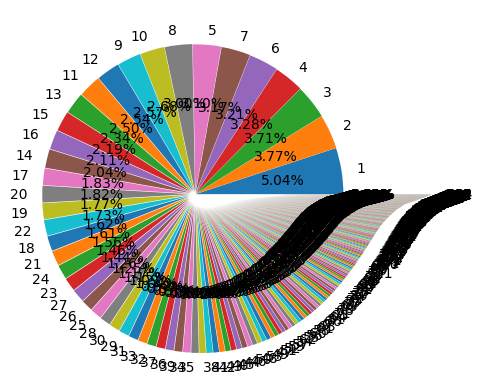

ProductRelated_Duration
auto operation pctdistance and lableNum


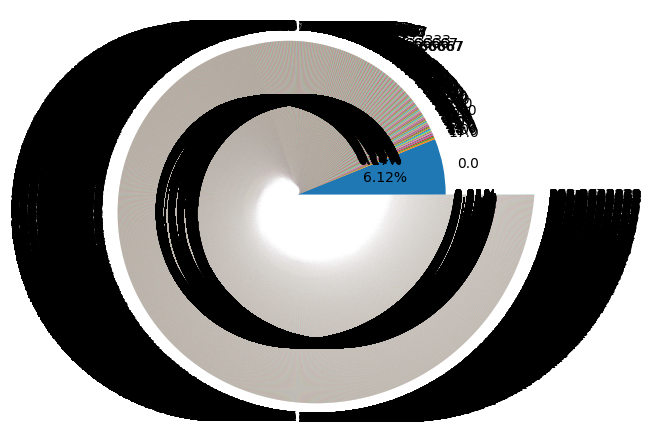

BounceRates
auto operation pctdistance and lableNum


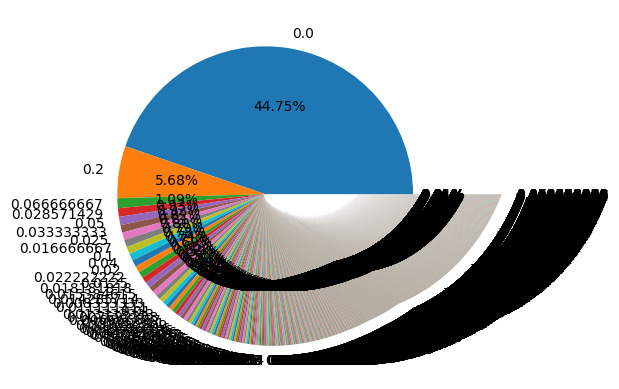

ExitRates
auto operation pctdistance and lableNum


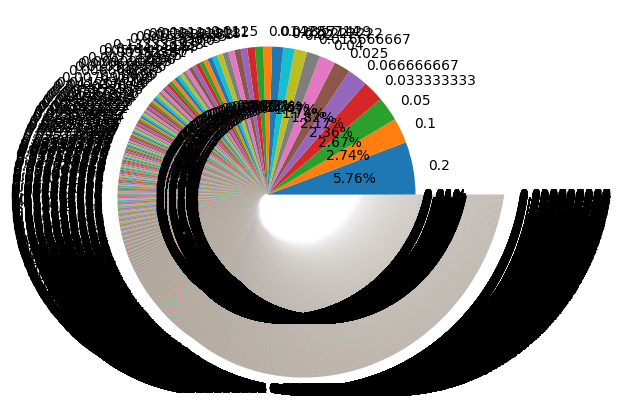

PageValues
auto operation pctdistance and lableNum


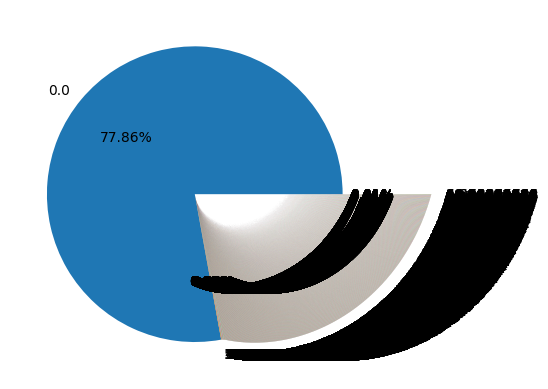

SpecialDay
auto operation pctdistance and lableNum


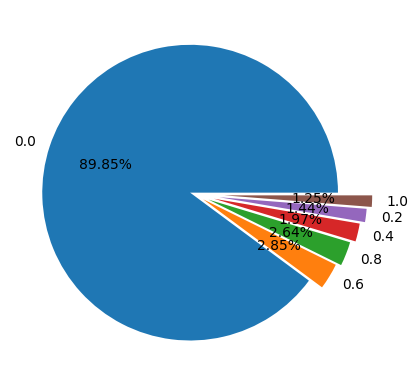

OperatingSystems
auto operation pctdistance and lableNum


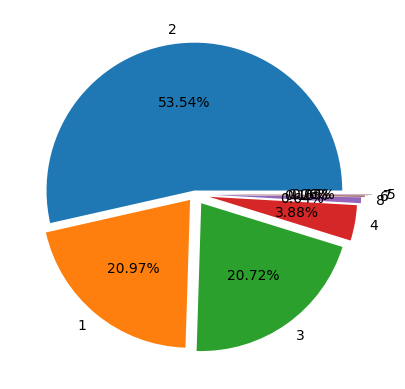

Browser
auto operation pctdistance and lableNum


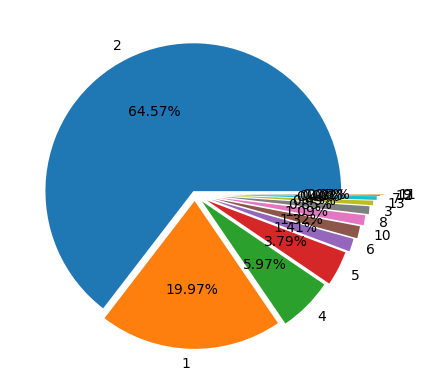

Region
auto operation pctdistance and lableNum


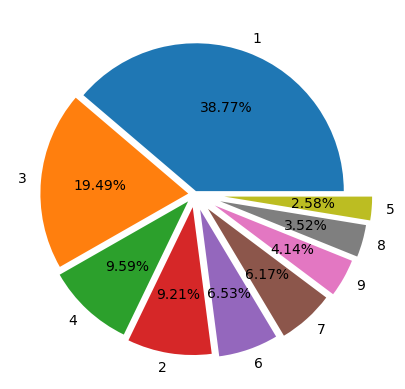

TrafficType
auto operation pctdistance and lableNum


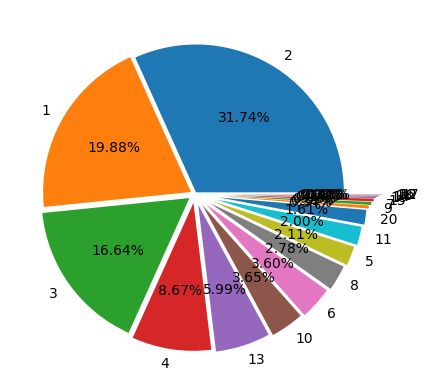

Weekend
auto operation pctdistance and lableNum


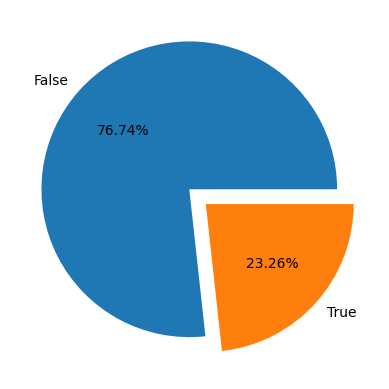

Revenue
auto operation pctdistance and lableNum


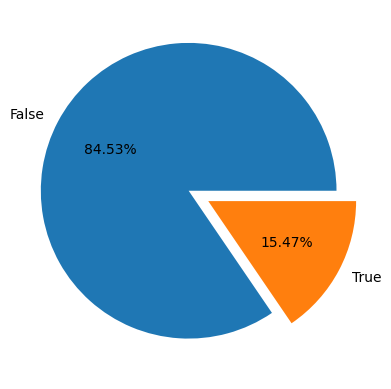

In [62]:
drowLabelPie(data_df_n,df_label_values_counts)

ProductRelated
auto operation pctdistance and lableNum


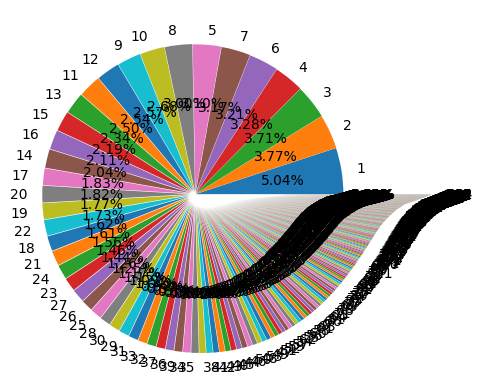

TrafficType
auto operation pctdistance and lableNum


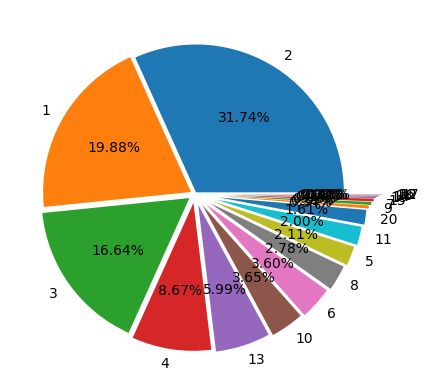

Administrative
auto operation pctdistance and lableNum


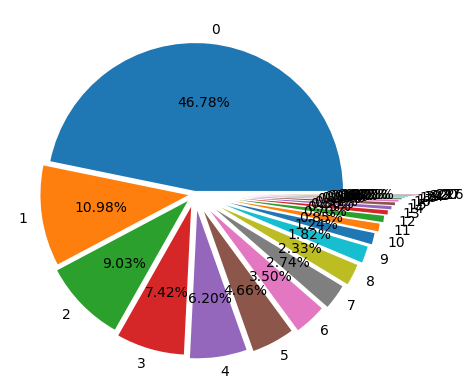

Revenue
auto operation pctdistance and lableNum


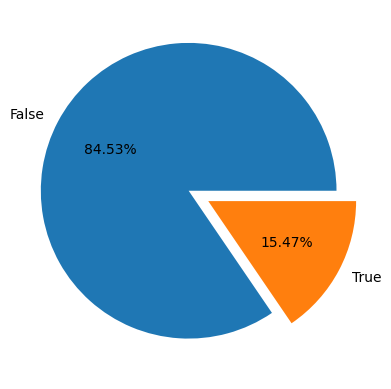

Weekend
auto operation pctdistance and lableNum


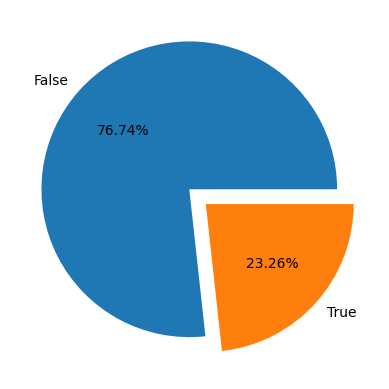

In [211]:
xgx = ['ProductRelated','TrafficType','Administrative','Revenue','Weekend']
drowLabelPie(xgx,df_label_values_counts)

Administrative


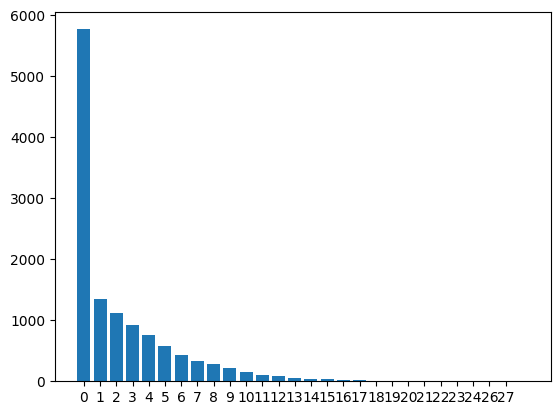

Informational


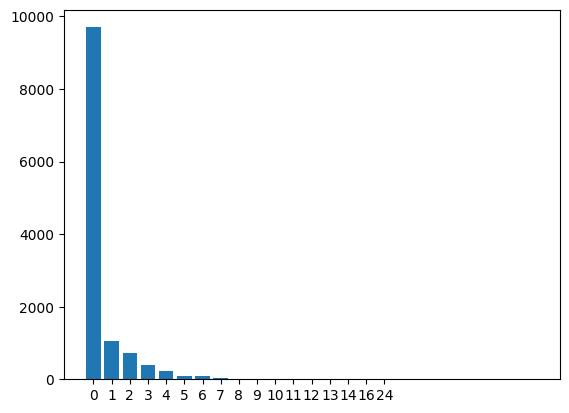

ProductRelated


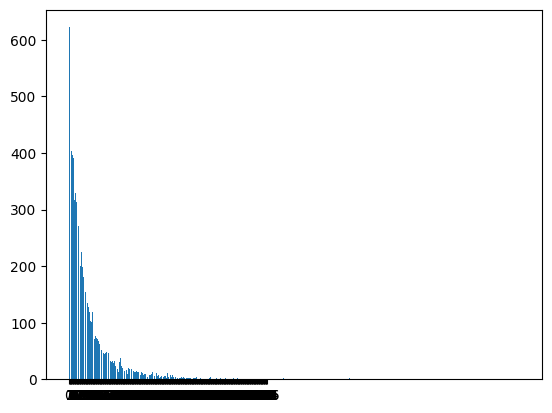

SpecialDay


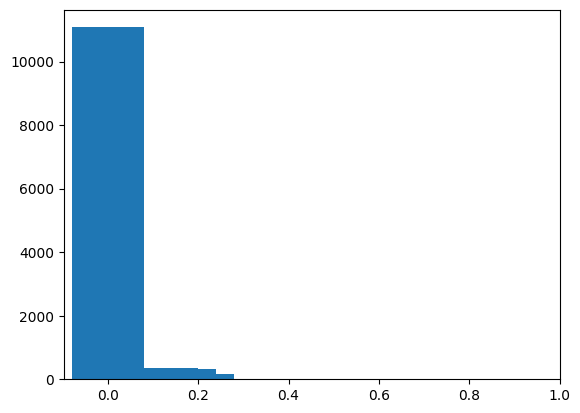

OperatingSystems


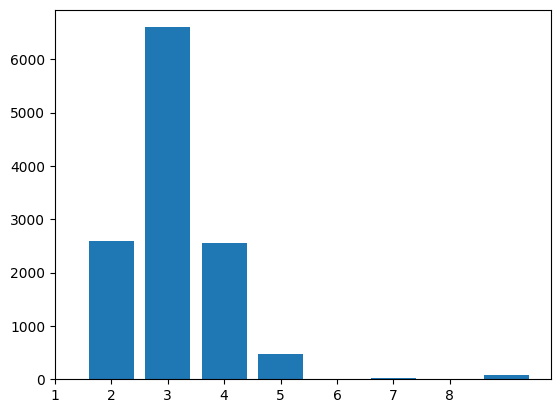

Browser


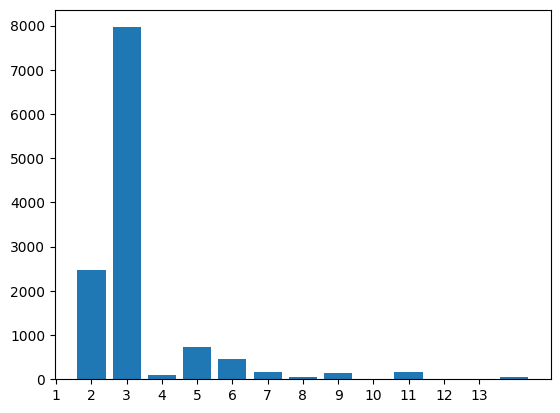

Region


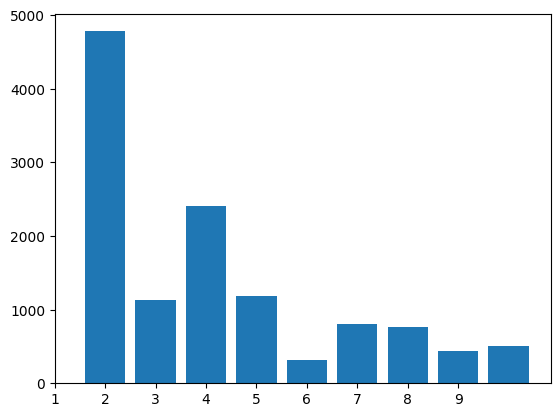

TrafficType


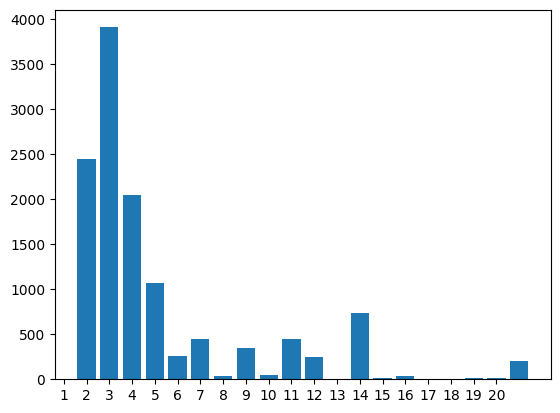

Weekend


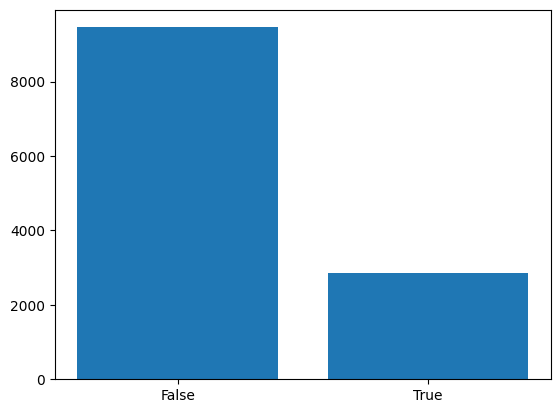

Revenue


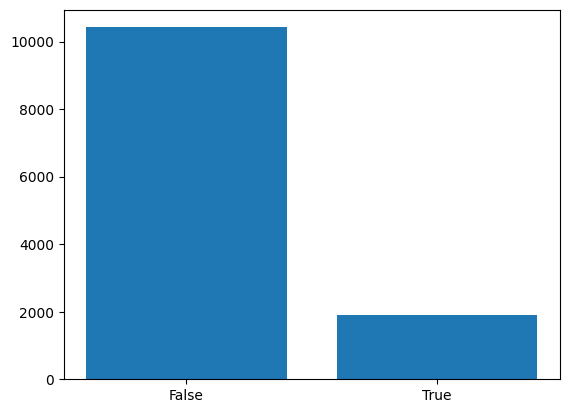

In [224]:
for iddn in data_df_n:
    dt = statisticOneLabel(data_df,iddn)
    if(len(dt.values.tolist())<512):
        print(iddn)
        pltbar([i[0] for i in dt.index],dt.values.tolist())